# Classifying  dimensionality in inorganic crystal structures using Convolutional Neural Networks

Classifying dimensionality in inorganic crystal structures has recently attracted a lot of attention due to its applications in energy materials. In this work a convolutional neural network is proven to reproduce human engineered classifcation algorithms with classifcation accuracies of more than 54% when the structures are split into six unique dimensionality classes. The network consists of a single 2-D convolutional layer with subsequent fully connected layers and outranked attempts of using 1-D CNNs. The findings suggest that such an architecture could potentially be used to use a semisupervised learning approach that creates its own dimensionality classes. This could lead from a human engineered algorithm, that biases the classification scheme, to a fully data-driven approach.

The data for this project is taken from the paper Haastrup, Sten, et al. “Definition of a scoring parameter to identify low-dimensional materials components” arXiv preprint arXiv:1806.03173 (2018) (https://arxiv.org/abs/1808.02114) which uses the inorganic crystal structures from the Crystallography Open Database (Gražulis, Saulius, et al. "Crystallography Open Database–an open-access collection of crystal structures." Journal of Applied Crystallography 42.4 (2009): 726-729.).

Start by importing needed libraries. For the manipulation and visualization of the atoms the Atomic simulation Environment package is needed (ASE - https://wiki.fysik.dtu.dk/ase/). This package is not needed for reproducing the CNN results.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#adjust fontsize
plt.rcParams.update({'font.size': 16})
import numpy as np

import torch
import torchvision
from torch.autograd import Variable

First I visualize some of the structures to shed light on how the input for the CNN looks. Shown is the k value defined as

$$
k = \frac{r_i^{cov} + r_i^{cov}}{d_{ij}}
$$

where $r_i^{cov}$ is the covalent radii of the i-th atom and $d_{ij}$ is the distance in between the atom of interest in real space. Those fingerprints were created using the python script <b> prepare_fingerprints.py </b>.

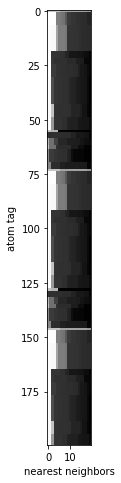

In [2]:
from ase.db import connect
from ase.visualize import view

# connect to databases
dbs_1 = connect('s_1.db')
dbs_2 = connect('s_2.db')
dbs_3 = connect('s_3.db')
dbs_01 = connect('s_01.db')
dbs_02 = connect('s_02.db')
dbs_03 = connect('s_03.db')

# change database and id to inspect any structure
row = dbs_03.get(id=23)
ks = row.data['ks']
#ks = padding_with_order(ks, n_max)

# visualize it using some sort of heat map, black and white is fine
plt.figure(figsize = (20,8))
plt.imshow(np.array(ks),cmap = 'gray')
plt.ylabel('atom tag')
plt.xlabel('nearest neighbors')
plt.savefig('2D_example_ks.pdf',dpi = 650)
view(row.toatoms(), viewer = 'x3d')

# Visualize data using PCAs

In order to get a better understanding of this classification task the PC are plotted. This should also support the final goal of a possible semisupervised approach for this classification problem.

In [3]:
# concatenate all databases and create input matrix X
dbs = [dbs_1,dbs_2,dbs_3,dbs_01,dbs_02,dbs_03]
classes = ['s_01','s_02','s_03','s_1','s_2','s_3']
classes_int = {'s_1': 0 ,'s_2': 1,'s_3': 2,'s_01': 3,'s_02': 4,'s_03': 5}

X= []
act_class = []
for i,db in enumerate(dbs):
    for row in db.select():
        X.append(np.array(db.get(id = row.id).data['ks']).reshape(4000))
        act_class.append(classes[i])

In [4]:
from sklearn import preprocessing
from scipy.linalg import svd

X = np.array(X)
print("Size of matrix X: " ,X.shape)
# get some PCA visualization in here
N,M = X.shape
# Subtract mean value from data
Y = preprocessing.scale(X)
Y = np.matrix(Y)
# PCA by computing SVD of Y
U,S,V = svd(Y,full_matrices=False)

# Compute variance explained by principal components
rho = (S*S) / (S*S).sum()
cum_rho = np.cumsum(rho)

#Project data onto principal components
V = V.T
# Project the centered data onto principal component space
Z = Y * V

Size of matrix X:  (9892, 4000)


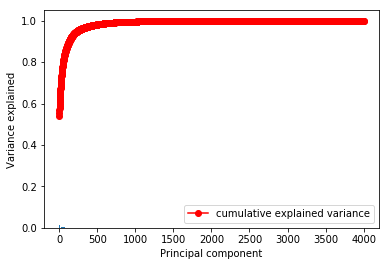

In [5]:
# Plot variance explained
f = plt.figure()
#subplot(2,1,1)
plt.plot(range(1,len(rho)+1),cum_rho,'o-', color = 'r',
      label='cumulative explained variance')
plt.bar(range(1,len(rho)+1), 
    rho, align = 'center')
plt.legend()
plt.xlabel('Principal component');
plt.ylabel('Variance explained');

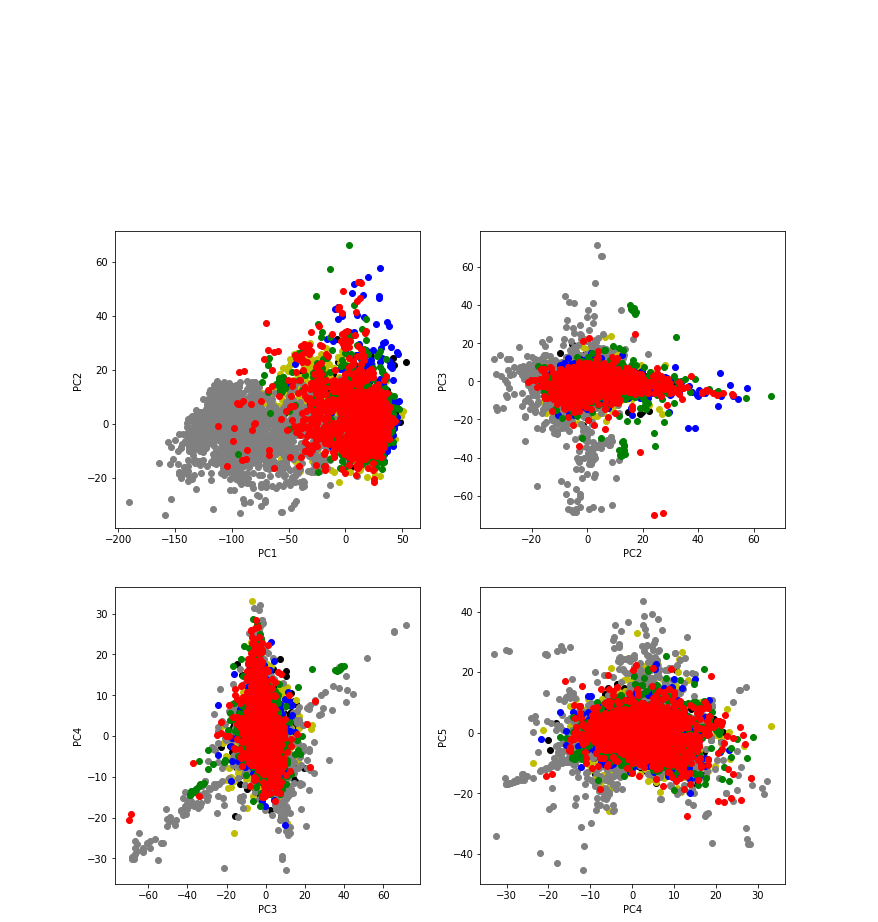

In [6]:
import matplotlib.lines as mlines
# Plot PCs of the data

def plot_PCA(i,j):
    #plt.figure(figsize=(12,8))
    for row in range(Y.shape[0]):
        #if row % 1000 == 0:
        #    print(row)
        if 1:
            if act_class[row] == 's_1':color = 'b';
            elif act_class[row] == 's_2':color = 'g';
            elif act_class[row] == 's_3':color = 'r';
            elif act_class[row] == 's_01':color = 'k';
            elif act_class[row] == 's_02':color = 'y';
            elif act_class[row] == 's_03':color = 'grey';
            
            plt.plot(Z[row,i], Z[row,j], 'o',color = '{0}'.format(color))

    plt.xlabel('PC{0}'.format(i+1))
    plt.ylabel('PC{0}'.format(j+1))
    
fig, axes = plt.subplots(2, 2, figsize=(12,12))

for index,(i,j) in enumerate([[0,1],[1,2],[2,3],[3,4]]):
    plt.subplot(2,2,index+1)
    plot_PCA(i,j)
    
fig.legend(numpoints=1, ncol = len(classes),
           bbox_to_anchor=(0., 0.99, 1., .15), borderaxespad=0,mode='expand',
           handles=[mlines.Line2D([], [], color='b', marker='o',
                              markersize=10, label='1-D',
                              linewidth = 0),
                    mlines.Line2D([], [], color='g', marker='o',
                              markersize=10, label='2-D',
                              linewidth = 0),
                    mlines.Line2D([], [], color='r', marker='o',
                              markersize=10, label='3-D',
                              linewidth = 0),
                   mlines.Line2D([], [], color='k', marker='o',
                              markersize=10, label='0+1-D',
                              linewidth = 0),
                   mlines.Line2D([], [], color='y', marker='o',
                              markersize=10, label='0+2-D',
                              linewidth = 0),
                   mlines.Line2D([], [], color='grey', marker='o',
                              markersize=10, label='0+3-D',
                              linewidth = 0),])

#plt.savefig('PCAS_lowDData.pdf',bbox_inches='tight',dpi = 600)

The PCA shows that especially the 0+3-D dimensionality should be separable from all other classes.

# Prepare test and training data

In [7]:
#function to select random samples each time
import random
def return_shuffle(array):
        random.shuffle(array)
        return array
    
def shuffle_train_data(X_train, y_train):
    X_train_shuffled,y_train_shuffled = [],[]
    
    indices_random = return_shuffle(np.arange(0,len(X_train),1))
    for ind in indices_random:
        X_train_shuffled.append(X_train[ind])
        y_train_shuffled.append(y_train[ind])
        
    return X_train_shuffled, y_train_shuffled
    

In [8]:
from operator import itemgetter

def ordered_k_values(ks):
    mean_values = sorted([[np.mean(k),k] for i,k in enumerate(ks)], 
                           key = itemgetter(0))

    ks = np.array([np.array(val[1]) for val in mean_values])
    
    return ks
    

In [9]:
# first decide in which classes to investigate
# choose from classes = ['s_01','s_02','s_03','s_1','s_2','s_3']
classes = ['s_01','s_02','s_03','s_1','s_2','s_3']
classes_int = {'s_1': 0,'s_2': 1,'s_3': 2,'s_01': 3,'s_02': 4,'s_03': 5}
# how many objects use to train and test? should be around 1500 training points available at least
n_investigate = 1000 # number for training set
nchannels, rows, n_nearest_neighbors = 1, 200, 20
# how many nearest neighbors for each atom? max in dataset for now is 20
# use 25% test set
n_valid = int(n_investigate * 0.25)
n_test  = int(n_investigate * 0.25)
ids_test = [] # to in the end analyze misclassified structures

data = {'X_train':[],
       'y_train':[],
       'X_valid':[],
       'y_valid':[],
       'X_test':[],
       'y_test':[]}

# select random indices, therefore random structures
for cl in classes:
    i = 0
    print('Fetching data for class %s'%cl)
    # choose correct database
    if cl == 's_1': db = dbs_1;
    if cl == 's_2': db = dbs_2;
    if cl == 's_3': db = dbs_3;
    if cl == 's_01': db = dbs_01;
    if cl == 's_02': db = dbs_02;
    if cl == 's_03': db = dbs_03;
        
    rand_ind  = return_shuffle(np.arange(1,len(db) + 1,1))
    for i,id in enumerate(rand_ind):

        if i == n_investigate: break;
        
        # choose ordered k-values as an input
        ks = np.array(db.get(id = int(id)).data['ks'])
        ks = np.array(ordered_k_values(ks))
        ks = np.array(ks[:,:n_nearest_neighbors])
        #atoms = db.get(id=int(id)).toatoms()

        if i < n_investigate - n_test - n_valid:
            data['X_train'].append(ks)
            data['y_train'].append(classes_int[cl])
        elif i < n_investigate - n_test and i >= n_investigate - n_test - n_valid:
            data['X_valid'].append(ks)
            data['y_valid'].append(classes_int[cl])
        else:
            data['X_test'].append(ks)
            data['y_test'].append(classes_int[cl])
            ids_test.append(int(id))

# only training data is shuffled, not test and validation data
x_train, y_train = shuffle_train_data(data['X_train'], data['y_train'])

x_train = np.array(x_train).astype('float32')
x_train = x_train.reshape((-1, nchannels, rows, n_nearest_neighbors))
x_valid = np.array(data['X_valid']).astype('float32')
x_valid = x_valid.reshape((-1, nchannels, rows, n_nearest_neighbors))
x_test = np.array(data['X_test']).astype('float32')
x_test = x_test.reshape((-1, nchannels, rows, n_nearest_neighbors))

targets_train = np.array(y_train).astype('int32')
targets_valid = np.array(data['y_valid']).astype('int32')
targets_test = np.array(data['y_test']).astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Fetching data for class s_01
Fetching data for class s_02
Fetching data for class s_03
Fetching data for class s_1
Fetching data for class s_2
Fetching data for class s_3
Information on dataset
x_train (3000, 1, 200, 20)
targets_train (3000,)
x_valid (1500, 1, 200, 20)
targets_valid (1500,)
x_test (1500, 1, 200, 20)
targets_test (1500,)


# Compare to a simple decision tree
See how good that one is when looking at different tree depths.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn import tree
X = np.array(data['X_train']).reshape(len(data['X_train']),4000)
Y = np.array(data['y_train'])
print(X.shape)
print(Y.shape)
clf = tree.DecisionTreeClassifier()
clf.fit(X,Y)

X_test = np.array(data['X_test']).reshape(len(data['X_test']),4000)
preds = clf.predict(X_test)
print('DEFAULT DEPTH')
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds))))

for depth in [2,6,8,12]:
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf.fit(X,Y)

    X_test = np.array(data['X_test']).reshape(len(data['X_test']),4000)
    preds = clf.predict(X_test)
    print('------------%i------------'%depth)
    print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds))))


(3000, 4000)
(3000,)
DEFAULT DEPTH

Test set Acc:  0.465333
------------2------------

Test set Acc:  0.390667
------------6------------

Test set Acc:  0.458667
------------8------------

Test set Acc:  0.496000
------------12------------

Test set Acc:  0.480000


# Define a convolutional neural network
A 2-D convolutional layer is used with a subsequent dropout layer (p=0.2) and two fully connected output layers. 

In [11]:
# define the network, after data exists
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# also get some activation functions in here
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
 
class Net(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.input_height = input_height
        self.input_width = input_width
        
        num_filters = 5
        stride = 5
        kernel_size= 5
        stride_2 = 1
        kernel_size_2 = 12
        # first conv layer
        self.conv_1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=num_filters,
                               kernel_size=kernel_size,
                               stride = stride,
                               padding=0)

        # dropout layer
        self.conv1_drop = nn.Dropout2d(p=0.2) # default: p=0.5
        
        # outpout layers
        self.l1_in_features = 800
        self.l_1 = nn.Linear(in_features=self.l1_in_features, 
                          out_features=100,
                          bias=True)
        self.l_out = nn.Linear(in_features=100, 
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x):
        # prepare 1D-CNN input
        batch_si, x2, x3, x4 = x.shape
        x = x.view(batch_si, x2 , x3, x4) #batch_size, n_channels, width*height
        x = x.permute(0,1,2,3)
        
        # conv layer
        x = relu(self.conv1_drop(self.conv_1(x)))
        
        # fully connected output layers
        x = x.view(batch_si, -1)
        x = relu(self.l_1(x))
        out = softmax(self.l_out(x), dim=1)
        
        return out
    

net = Net(1,200,n_nearest_neighbors,len(classes))
print(net)

Net(
  (conv_1): Conv2d(1, 5, kernel_size=(5, 5), stride=(5, 5))
  (conv1_drop): Dropout2d(p=0.2)
  (l_1): Linear(in_features=800, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=6, bias=False)
)


# Define a loss function and optimizer


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters())

In [13]:
#Test the forward pass with dummy data
batch_size = 20
x = np.random.normal(0,1, (batch_size, 1, 200,n_nearest_neighbors)).astype('float32')
out = net(Variable(torch.from_numpy(x)))
out.size(), out

(torch.Size([20, 6]), tensor([[0.1660, 0.1576, 0.1711, 0.1571, 0.1696, 0.1786],
         [0.1806, 0.1700, 0.1618, 0.1630, 0.1628, 0.1619],
         [0.1495, 0.1561, 0.1574, 0.1656, 0.1963, 0.1752],
         [0.1917, 0.1618, 0.1518, 0.1583, 0.1843, 0.1522],
         [0.1567, 0.1706, 0.1742, 0.1624, 0.1636, 0.1725],
         [0.1586, 0.1822, 0.1581, 0.1484, 0.1800, 0.1725],
         [0.1618, 0.1666, 0.1628, 0.1550, 0.1760, 0.1778],
         [0.1537, 0.1564, 0.1766, 0.1580, 0.1830, 0.1724],
         [0.1651, 0.1786, 0.1704, 0.1476, 0.1826, 0.1558],
         [0.1484, 0.1614, 0.1823, 0.1584, 0.1947, 0.1548],
         [0.1532, 0.1892, 0.1774, 0.1485, 0.1612, 0.1705],
         [0.1664, 0.1631, 0.1765, 0.1496, 0.1788, 0.1656],
         [0.1621, 0.1723, 0.1747, 0.1525, 0.1822, 0.1562],
         [0.1465, 0.1745, 0.1632, 0.1647, 0.1783, 0.1728],
         [0.1720, 0.1672, 0.1673, 0.1642, 0.1686, 0.1607],
         [0.1809, 0.1531, 0.1648, 0.1682, 0.1678, 0.1652],
         [0.1786, 0.1662, 0.1553, 0

In [14]:
def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()
    return x.data.numpy()

# Train the network

Epoch  1 : Train Loss 2.123477 , Train acc 0.312000, Valid acc 0.314000
Epoch 21 : Train Loss 1.957229 , Train acc 0.442000, Valid acc 0.433333
Epoch 41 : Train Loss 1.888694 , Train acc 0.483667, Valid acc 0.463333
Epoch 61 : Train Loss 1.862910 , Train acc 0.519333, Valid acc 0.469333
Epoch 81 : Train Loss 1.830759 , Train acc 0.542000, Valid acc 0.492000
Epoch 101 : Train Loss 1.818526 , Train acc 0.558000, Valid acc 0.486000
Finished Training

Test set Acc:  0.482667


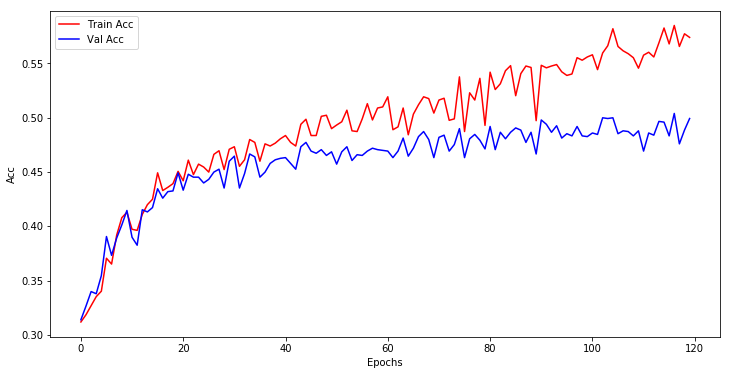

In [15]:
from sklearn.metrics import accuracy_score

BATCH_SIZE = 50
num_epoch = 120
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // BATCH_SIZE
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // BATCH_SIZE

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

#max_iter = 10000
#log_every = 100
#eval_every = 100

for epoch in range(num_epoch):  # loop over the dataset multiple times
    try: 
        
        ## TRAIN
        cur_loss = 0
        costs = []
        correct = 0
        net.train()
        
        for i in range(num_batches_train):
            
            idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples_train))
            X_batch_tr = Variable(torch.from_numpy(x_train[idx]))
            y_batch_tr = Variable(torch.from_numpy(targets_train[idx])).long()

            
            output = net(X_batch_tr)
            batch_loss = criterion(output, y_batch_tr)
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            cur_loss += batch_loss
            
        losses.append(cur_loss/BATCH_SIZE)
        
        ## EVALUATE TRAINING
        train_preds, train_targs = [], []
        net.eval()
        for i in range(num_batches_train):

            idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples_train))
            X_batch_val = Variable(torch.from_numpy(x_train[idx]))
            output = net(X_batch_val)
            preds = torch.max(output,1)[1]
            
            train_targs += list(targets_train[idx])
            train_preds += list(preds.data.numpy())

        # EVALUATE VALIDATION
        val_preds, val_targs = [], []
        net.eval()
        for i in range(num_batches_valid):

            idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples_valid))
            X_batch_val = Variable(torch.from_numpy(x_valid[idx]))
            output = net(X_batch_val)
            preds = torch.max(output,1)[1]
            
            val_targs += list(targets_valid[idx])
            val_preds += list(preds.data.numpy())

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)
        
        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 20 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
            
    # some safety before I break my PC
    except KeyboardInterrupt:
        print('\nKeyboardInterrupt')
        break

print('Finished Training')
epoch = np.arange(len(train_acc))
plt.figure(figsize=(12,6))
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.savefig('Learning_curve.pdf',dpi = 650)

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

# Evaluation of classification
Look at misclassified structures and identify crystals with interesting properties that have ben misclassified in the underlying paper.

In [16]:
# which ones have been misclassified!?
classes_int = {'s_1': 0,'s_2': 1,'s_3': 2,'s_01': 3,'s_02': 4,'s_03': 5}

failed_cases = [[int(id),targets_test[i]] for i,id in enumerate(ids_test) if targets_test[i] != preds.data.numpy()[i]] # [[id,actual_class]]



Text(0.5,0,'# misclassifications')

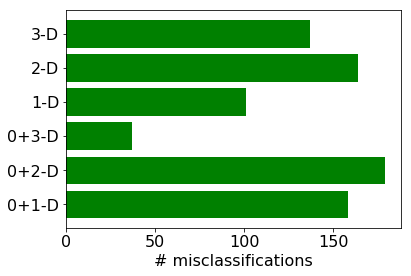

In [17]:
failed_classes = [i for x,i in failed_cases]
plot_list = [failed_classes.count(0),
            failed_classes.count(1),
            failed_classes.count(2),
            failed_classes.count(3),
            failed_classes.count(4),
            failed_classes.count(5)]
classes = ['0+1-D','0+2-D','0+3-D','1-D','2-D','3-D']
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
y_pos = np.arange(len(classes))
ax.barh(y_pos, plot_list, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.set_xlabel('# misclassifications')

# Interesting structures that are most probably misclassified by other method
I want to keep track of some that I think are interesting but are misclassified using the approach in the paper

classified 2D: id = 5 from 3D database, actually even looks quasi 1D
id = 1705, again clear diffusion paths.

# Conclusion and Outlook
A dataset of 12,000 different inorganic crystal structures have been classified using a CNN, while the classification was taken from literature that used a heuristic approach to classify the materials. The CNN network tried to mimic this classification approach and reached an accuracy of around 54% which is way better than guessing for a classication problem with six classes. It also outperforms less complex machine learning models like a decision tree by more than 10% giving us confidence in the used approach.
The final goal will now be to use an unsupervised approach to cluster the data. Letting an algorithm build the fingerprints needed for a clear separation between geometrical crystal structures can lead to really interesting classes. In front of all, it elminates the human introduced bias into the classifcation scheme. It is expected, that especially structures with unique geometrical properties could be identified. This could possibly lead to a data-driven classification scheme, that leads to an end of human engineered algorithms and could become a standard for future crystal structures with applications in fields like batteries, catalysis and solar energy materials.